In [9]:
import numpy as np
import matplotlib.pyplot as plt
import sys 
from pathlib import Path
import scipy.stats
import scipy.special
from tqdm import tqdm 

sys.path.insert(0, str(Path().absolute().parents[1]))

from cv_prince.chap_07_complex_densities.gaussians import Gaussian
from notebooks.utils import create_cov_based_on_angle_and_axis_scale

In [10]:
# Create a Gaussian with outliers
num_samples = 10000
outliers_rate = 0.001
num_outliers = int(num_samples * outliers_rate)
rng = np.random.default_rng(seed=12345)

# Sample inliers
mean = np.array((1.0, 4.0))
cov = create_cov_based_on_angle_and_axis_scale(30, (1, 1/8))
gaussian = Gaussian(mean=mean, cov=cov)

samples = gaussian.sample(n=num_samples-num_outliers, rng=rng)

# Sample outliers
samples_min = samples.min(axis=0)
samples_max = samples.max(axis=0)
samples_extent = samples_max - samples_min

outliers = np.empty((0, 2), dtype=np.float64)
while outliers.shape[0] < num_outliers:
    current_outliers = rng.uniform(
        low=samples_min - 0.5 * samples_extent, 
        high= samples_max + 0.5 * samples_extent,
        size=(num_outliers - outliers.shape[0],2)
    )

    mah_dist = gaussian.mahalanobis_dist(current_outliers)
    current_outliers = current_outliers[mah_dist > 5, :]  # Make sure we only keep actual outliers
    outliers = np.concat([outliers, current_outliers], axis=0)

# Combine all samples
all_samples = np.concat([samples, outliers], axis=0)

In [11]:
rv = scipy.stats.multivariate_t(loc=mean, shape=cov, df=10)
# all_samples = rv.rvs(size=num_samples)

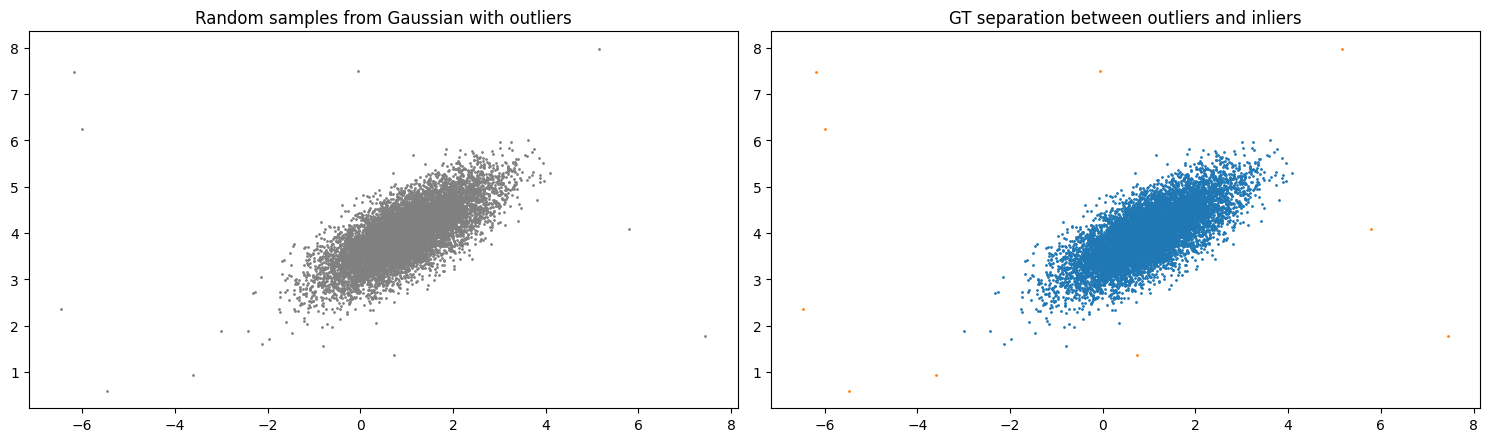

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].scatter(all_samples[:, 0], all_samples[:, 1], s=1, color="gray")
axes[0].set_title("Random samples from Gaussian with outliers")
axes[0].set_aspect("equal")

axes[1].scatter(samples[:, 0], samples[:, 1], s=1)
axes[1].scatter(outliers[:, 0], outliers[:, 1], s=1)
axes[1].set_title("GT separation between outliers and inliers")
axes[1].set_aspect("equal")

fig.tight_layout()

In [13]:
class ExpectationMaximisationStudent:

    def __init__(self, seed: int | None = None):
        self.mean: np.ndarray | None = None
        self.cov: np.ndarray | None = None
        self.inv_cov: np.ndarray | None = None
        self.nu: float | None = None

        self.ndims: int | None = None

        self.__rng = np.random.default_rng(seed)
        self.__is_fitted: bool = False

    def fit(self, samples: np.ndarray, max_iter: int=1000) -> None:
        self.initialise_params(samples)

        for _ in tqdm(range(max_iter)):
            exp_h, exp_logh = self.perform_e_step(samples)
            self.perform_m_step(samples, exp_h, exp_logh)

    def initialise_params(self, samples: np.ndarray) -> None:
        self.ndims = samples.shape[1]

        self.mean = np.mean(samples, axis=0)
        self.cov = np.cov(samples, rowvar=False)
        self.inv_cov = np.linalg.inv(self.cov)
        self.nu = 1000

    def perform_e_step(self, samples) -> tuple[np.ndarray, np.ndarray]:
        alpha = (self.nu + self.ndims)/2
        
        x_mu = samples - self.mean[np.newaxis, :]  # (N, D)
        x_mu_sq = x_mu[:, np.newaxis, :] @ self.inv_cov[np.newaxis, ...]  # (N, 1, D)
        x_mu_sq = x_mu_sq @ x_mu[..., np.newaxis]  # (N, 1, 1)
        x_mu_sq = x_mu_sq[..., 0, 0]  # (N,) 

        beta = (x_mu_sq + self.nu)/2
        
        exp_h = alpha / beta
        exp_logh = scipy.special.digamma(alpha) - np.log(beta)

        return exp_h, exp_logh
    
    def perform_m_step(self, samples: np.ndarray, exp_h: np.ndarray, exp_logh: np.ndarray) -> None:
        nsamples = samples.shape[0]

        self.mean = np.sum(exp_h[:, np.newaxis] * samples, axis=0) / exp_h.sum()

        x_mu = samples - self.mean[np.newaxis, :]  # (N, D)
        x_mu_sq = x_mu[..., np.newaxis] @ x_mu[:, np.newaxis, :]   # (N, D, D)
        self.cov = 1 / nsamples * np.sum(exp_h[:, np.newaxis, np.newaxis] * x_mu_sq, axis=0)
        self.inv_cov = np.linalg.inv(self.cov)

        def cost_func_nu(nu):
            nu_2 = nu / 2
            term1 = nsamples * nu_2 * np.log(nu_2) 
            term2 = -nsamples * scipy.special.loggamma(nu_2)
            term3 = (nu_2 - 1) * exp_logh.sum()
            term4 = -nu_2 * exp_h.sum()

            return term1 + term2 + term3 + term4
        
        best_cost = cost_func_nu(1)
        best_nu = 1
        for nu in np.arange(0.5, 1000, 0.5):
            cost = cost_func_nu(nu)
            if cost > best_cost:
                best_cost = cost
                best_nu = nu

        self.nu = best_nu
 

    @property
    def rng(self) -> np.random.Generator:
        """Access the random generator"""
        return self.__rng

    @property
    def is_fitted(self) -> bool:
        """Checks whether the model has been fitted or not"""
        return self.__is_fitted

    def __str__(self):
        with np.printoptions(precision=3):
            return (
                "GMM with the following parameters \n"
                f"* mean: \n{self.mean} \n\n"
                f"* cov : \n{self.cov} \n\n"
                f"* nu  : \n{self.nu} \n"
            )

In [14]:
print(mean)
print(cov)

[1. 4.]
[[0.78125    0.37888611]
 [0.37888611 0.34375   ]]


In [15]:
em_fitter = ExpectationMaximisationStudent(seed=12345)
em_fitter.fit(all_samples, max_iter=200)
print(em_fitter)

100%|██████████| 200/200 [00:02<00:00, 68.04it/s]

GMM with the following parameters 
* mean: 
[0.986 3.993] 

* cov : 
[[0.741 0.361]
 [0.361 0.334]] 

* nu  : 
38.5 



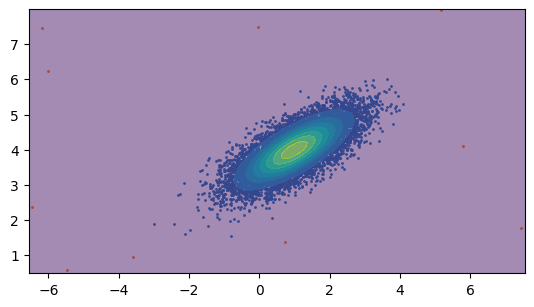

In [16]:
rv_fitted = scipy.stats.multivariate_t(loc=em_fitter.mean, shape=em_fitter.cov, df=em_fitter.nu)

all_samples_min = all_samples.min(axis=0)
all_samples_max = all_samples.max(axis=0)

x ,y = np.meshgrid(
    np.arange(all_samples_min[0]-0.1, all_samples_max[0]+0.1, 0.1), 
    np.arange(all_samples_min[1]-0.1, all_samples_max[1]+0.1, 0.1)
)
coords = np.stack([x, y], axis=-1)

fig, ax = plt.subplots(1, 1)
ax.set_aspect('equal')
plt.scatter(samples[:, 0], samples[:, 1], s=1)
plt.scatter(outliers[:, 0], outliers[:, 1], s=1)
plt.contourf(x, y, rv_fitted.pdf(coords), alpha=0.5)